In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
data_path = '../data/datasets/synthetic_data_stabilization_disturbance_2.parquet'

In [25]:
df = pd.read_parquet(path=data_path)

In [26]:
N = 10
df = pd.concat([df] * N, ignore_index=True)

In [27]:
df.shape

(1500010, 8)

In [40]:
window_length = 4000
number_windows = len(df) // window_length + (len(df) % window_length != 0)

In [50]:
%%timeit
sliding_windows = np.array_split(df, number_windows)
random.shuffle(sliding_windows)

18.4 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%%timeit
sliding_windows = []
for i in range(number_windows):
    first_index = i * window_length
    last_index = first_index + window_length
    window = df.iloc[first_index: last_index]
    sliding_windows.append(window)
random.shuffle(sliding_windows)
# shuffled_dataset = pd.concat(sliding_windows, ignore_index=True)

2.31 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit
sliding_windows = np.lib.stride_tricks.sliding_window_view(df.to_numpy(), (window_length, df.shape[1]))
random_indices = np.random.permutation(number_windows)
shuffled_sliding_windows = sliding_windows[random_indices]
# shuffled_dataset = pd.DataFrame(shuffled_sliding_windows.reshape(-1, shuffled_sliding_windows.shape[-1]), columns=df.columns)

4.63 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
def plot_data(data: pd.DataFrame, title: str, init: int = 0, end:int = 200) -> None:
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
    axs = axs.flatten()

    for idx, column in enumerate(data.columns):
        axs[idx].plot(data[column][init:end])
        axs[idx].set_title(column)

    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    fig.suptitle(title)

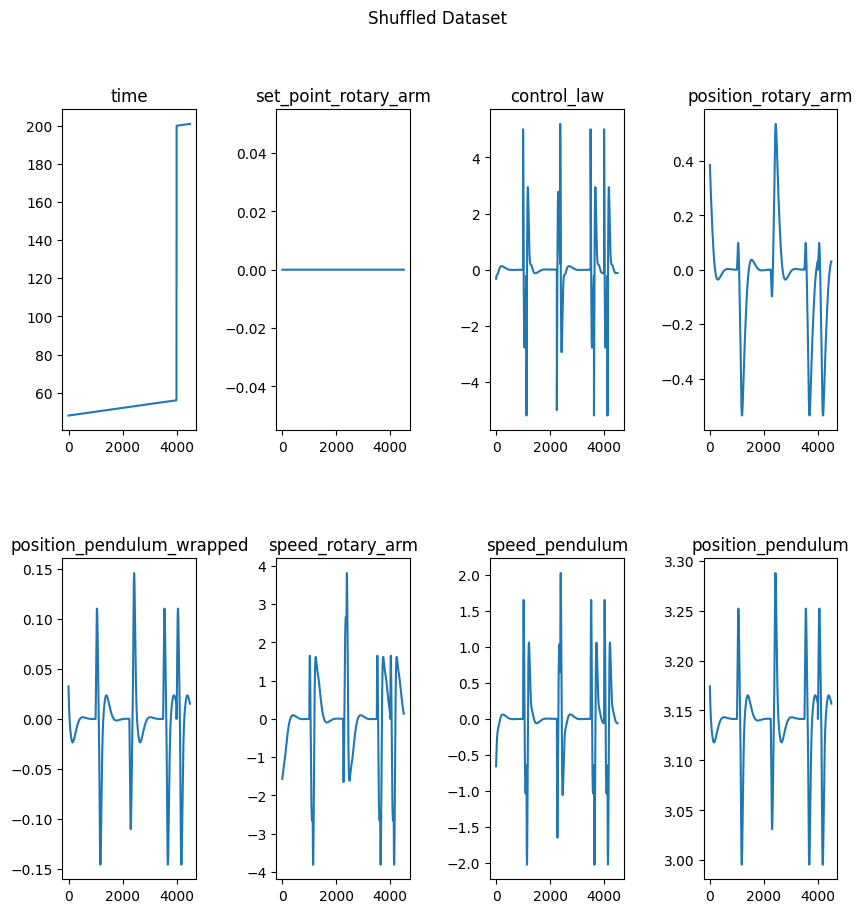

In [64]:
plot_data(data=shuffled_dataset,
          title='Shuffled Dataset',
          end=1500*3)

# Analyze Raw Data

In [3]:
path_data = r'C:\PROGRAMACION\PENDULO INVERTIDO\Pendulo Invertido Diego\Python-Furuta-Pendulum\data\datasets\stabilization_synthetic_data.parquet'

In [4]:
data = pd.read_parquet(path=path_data)
data.tail()

,set_point_rotary_arm,control_law,position_rotary_arm,position_pendulum_wrapped,speed_rotary_arm,speed_pendulum
49999996,0.349066,0.000028,0.349051,-0.000004,-0.000051,0.000014
49999997,0.349066,0.000028,0.349051,-0.000004,-0.000050,0.000014
49999998,0.349066,0.000028,0.349051,-0.000004,-0.000049,0.000014
49999999,0.349066,0.000028,0.349050,-0.000004,-0.000048,0.000014
50000000,-0.349066,9.594650,0.349050,-0.000004,-0.000047,0.000014


In [5]:
data.shape

(50000001, 6)

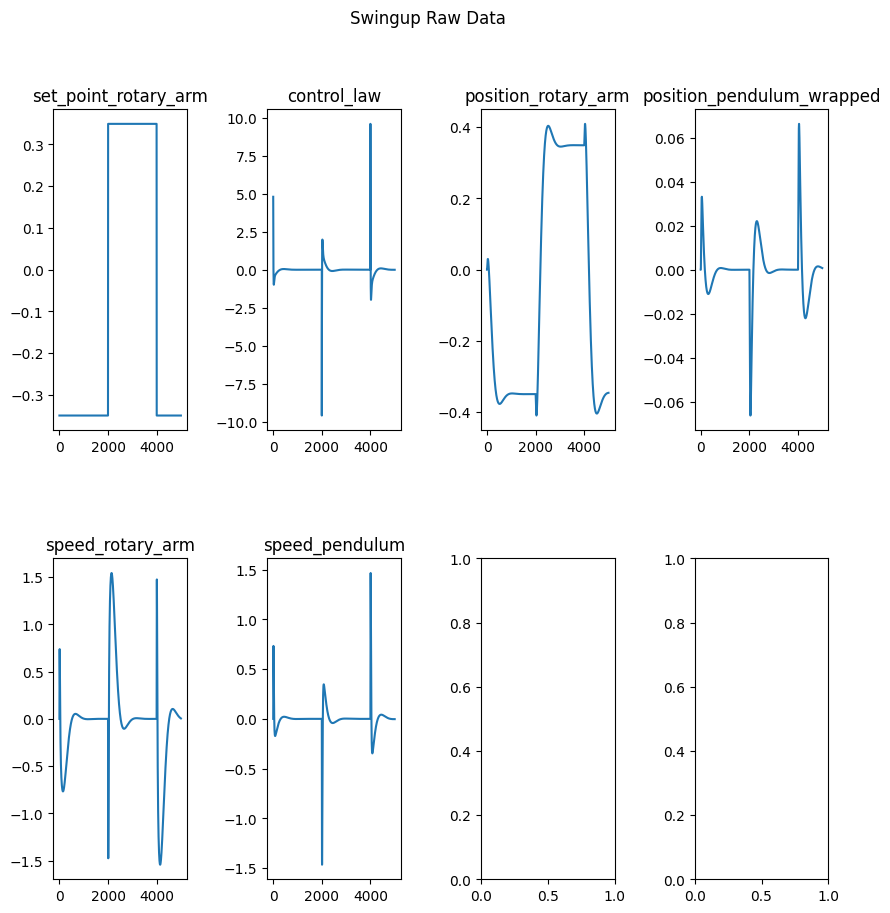

In [9]:
plot_data(data=data, title='Swingup Raw Data', init=0, end=5000)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100938 entries, 0 to 100937
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       100938 non-null  float64
 1   set_point_rotary_arm       100938 non-null  float64
 2   control_law                100938 non-null  float64
 3   position_rotary_arm        100938 non-null  float64
 4   position_pendulum_wrapped  100938 non-null  float64
 5   speed_rotary_arm           100938 non-null  float64
 6   speed_pendulum             100938 non-null  float64
 7   position_pendulum          100938 non-null  float64
dtypes: float64(8)
memory usage: 6.2 MB


In [8]:
dataset_stats = data.describe().transpose()
dataset_stats

,count,mean,std,min,25%,50%,75%,max
time,100938.0,100.937000,58.276870,0.000000,50.468500,100.937000,151.405500,201.874000
set_point_rotary_arm,100938.0,-0.003244,0.349053,-0.349066,-0.349066,-0.349066,0.349066,0.349066
control_law,100938.0,-0.065589,4.975401,-10.000000,-1.706507,-0.032990,1.635560,10.000000
position_rotary_arm,100938.0,-0.025371,0.448112,-1.509437,-0.411107,-0.009204,0.303728,2.110758
position_pendulum_wrapped,100938.0,0.004265,1.433323,-3.141593,-0.788466,-0.009204,0.855961,3.138525
speed_rotary_arm,100938.0,-0.002084,3.327051,-13.648693,-1.049030,-0.004347,1.041877,15.827819
speed_pendulum,100938.0,0.202134,9.414936,-27.392518,-2.702186,0.102083,3.744968,27.456403
position_pendulum,100938.0,20.516278,13.474467,-3.209088,9.415574,16.748002,30.623625,47.182181


In [9]:
def plot_histogram(data: pd.DataFrame) -> None:
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

    for idx, column in enumerate(data.columns):
        row = idx // 4
        col = idx % 4
        data[column].plot.hist(ax=axs[row, col], title=column)
    plt.show()
    fig.subplots_adjust(hspace=0.8, wspace=0.8)

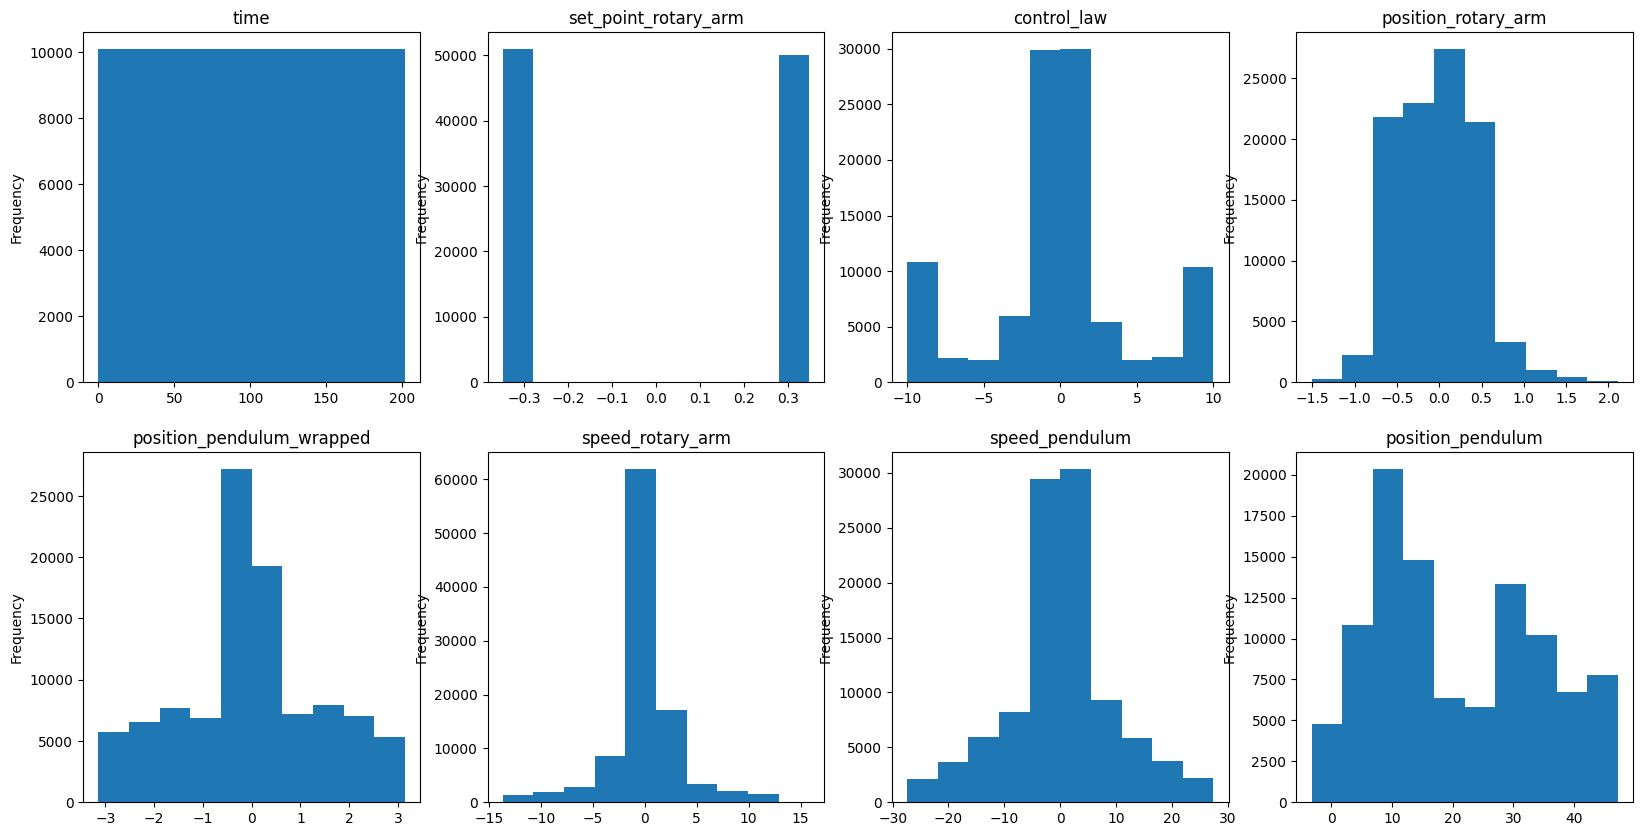

In [10]:
plot_histogram(data)

In [47]:
def normalize(dataframe: pd.DataFrame, stats: pd.DataFrame) -> pd.DataFrame:
    return (dataframe - stats['mean']) / stats['std']

# Scale Data with MinMaxScaler

In [29]:
from sklearn.preprocessing import MinMaxScaler

## Range 0 - 1

First I am going to check scaling with a range from 0 to 1.

In [30]:
min_max_scaler_range_0_to_1 = MinMaxScaler(feature_range=(0, 1))
min_max_scaler_range_0_to_1.fit(data)
scaled_data = min_max_scaler_range_0_to_1.transform(data)

In [38]:
columns = ['time', 'setpoint_rotary_arm', 'control_law', 'position_rotary_arm', 'position_pendulum_wrapped', 'speed_rotary_arm', 'speed_pendulum', 'position_pendulum']

scaled_df_data = pd.DataFrame(scaled_data, columns=columns)

scaled_df_data.head()

,time,setpoint_rotary_arm,control_law,position_rotary_arm,position_pendulum_wrapped,speed_rotary_arm,speed_pendulum,position_pendulum
0,0.000000e+00,0.0,0.750000,0.499998,0.500000,0.500000,0.500000,0.500000
1,2.000000e-08,0.0,0.750000,0.499998,0.500000,0.528452,0.543066,0.500000
2,4.000000e-08,0.0,0.738655,0.500573,0.501743,0.556179,0.585001,0.501743
3,6.000000e-08,0.0,0.718663,0.501708,0.505184,0.581925,0.623926,0.505184
4,8.000000e-08,0.0,0.692623,0.503363,0.510200,0.604771,0.658472,0.510200


With respect to raw data, the histogram distribution is the same but the values of the data has change to the specified range.

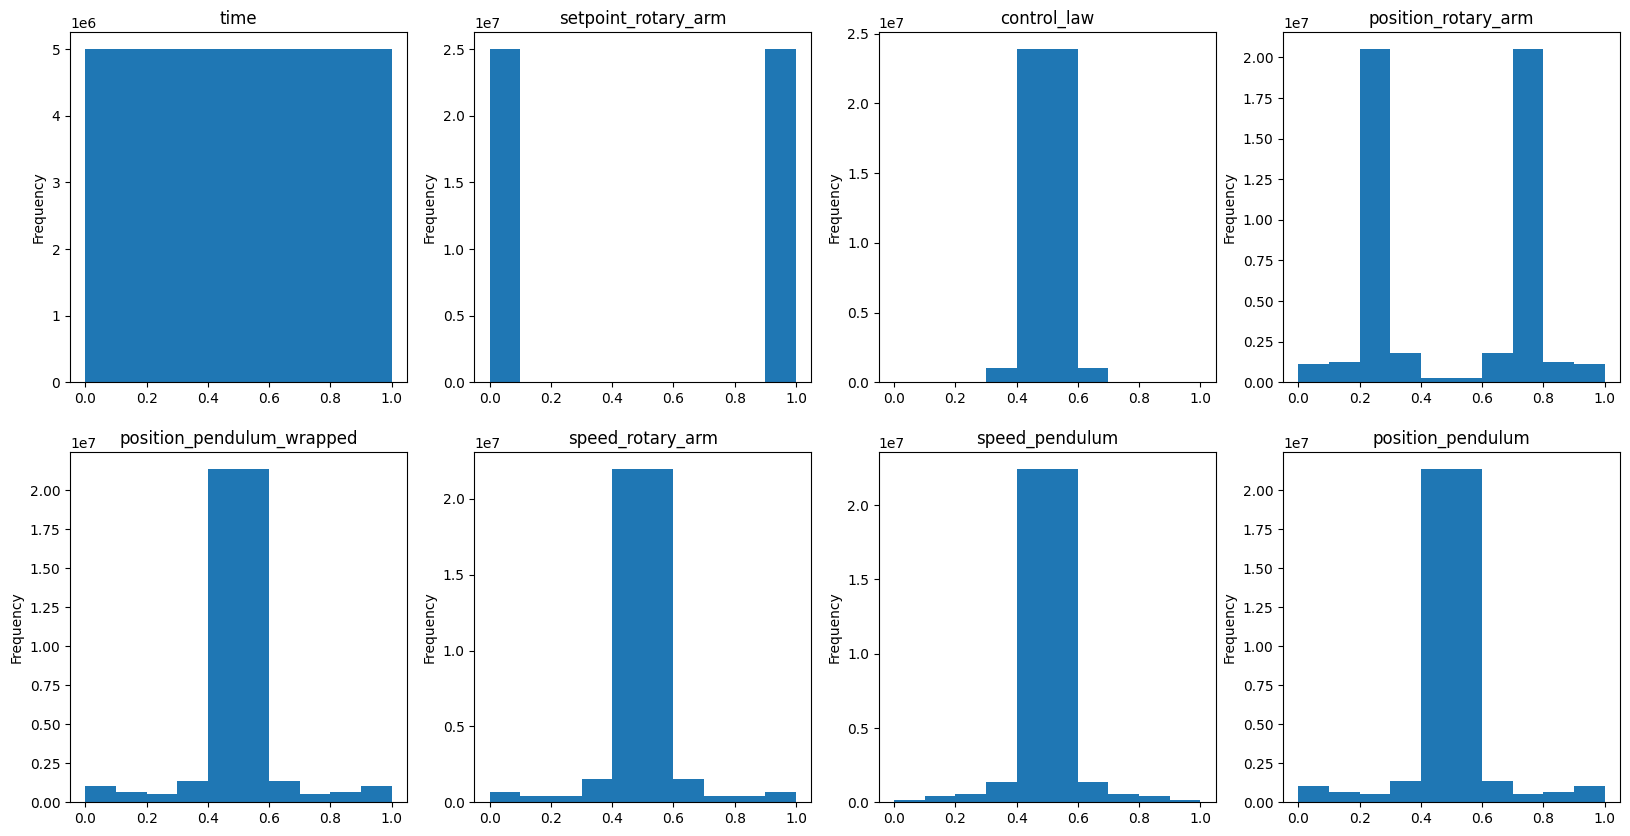

In [39]:
plot_histogram(scaled_df_data)

Now the features have all the same mean value and standard variation is closer from one to other.

In [40]:
scaled_df_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,50000001.0,0.5,0.288675,0.0,0.250000,0.500000,0.750000,1.0
setpoint_rotary_arm,50000001.0,0.5,0.500000,0.0,0.000000,0.000000,1.000000,1.0
control_law,50000001.0,0.5,0.046529,0.0,0.499821,0.500000,0.500179,1.0
position_rotary_arm,50000001.0,0.5,0.254743,0.0,0.263527,0.498763,0.736473,1.0
position_pendulum_wrapped,50000001.0,0.5,0.121557,0.0,0.499045,0.500000,0.500955,1.0
speed_rotary_arm,50000001.0,0.5,0.100804,0.0,0.499263,0.500000,0.500737,1.0
speed_pendulum,50000001.0,0.5,0.076876,0.0,0.499547,0.500000,0.500453,1.0
position_pendulum,50000001.0,0.5,0.121557,0.0,0.499045,0.500000,0.500955,1.0


In [41]:
data.describe().transpose()['std']

time                         28867.514326
setpoint_rotary_arm              0.349066
control_law                      0.779599
position_rotary_arm              0.376040
position_pendulum_wrapped        0.058473
speed_rotary_arm                 1.502962
speed_pendulum                   0.748453
position_pendulum                0.058473
Name: std, dtype: float64

In [42]:
scaled_df_data.describe().transpose()['std']

time                         0.288675
setpoint_rotary_arm          0.500000
control_law                  0.046529
position_rotary_arm          0.254743
position_pendulum_wrapped    0.121557
speed_rotary_arm             0.100804
speed_pendulum               0.076876
position_pendulum            0.121557
Name: std, dtype: float64

# Range -1 - 1

Now, let's check out the differences if I scale within a range from -1 to 1.

In [43]:
min_max_scaler_range_1_to_1 = MinMaxScaler(feature_range=(-1, 1))
min_max_scaler_range_1_to_1.fit(data)
scaled_data_minus1_to_1 = min_max_scaler_range_1_to_1.transform(data)

In [44]:
scaled_minus1_to_1_df_data = pd.DataFrame(scaled_data_minus1_to_1, columns=columns)

scaled_minus1_to_1_df_data.head()

,time,setpoint_rotary_arm,control_law,position_rotary_arm,position_pendulum_wrapped,speed_rotary_arm,speed_pendulum,position_pendulum
0,-1.0,-1.0,0.500000,-0.000004,-9.992007e-16,8.881784e-16,-8.719692e-13,0.000000
1,-1.0,-1.0,0.500000,-0.000004,-9.992007e-16,5.690455e-02,8.613163e-02,0.000000
2,-1.0,-1.0,0.477310,0.001146,3.486525e-03,1.123582e-01,1.700024e-01,0.003487
3,-1.0,-1.0,0.437326,0.003415,1.036806e-02,1.638492e-01,2.478519e-01,0.010368
4,-1.0,-1.0,0.385245,0.006725,2.040086e-02,2.095416e-01,3.169446e-01,0.020401


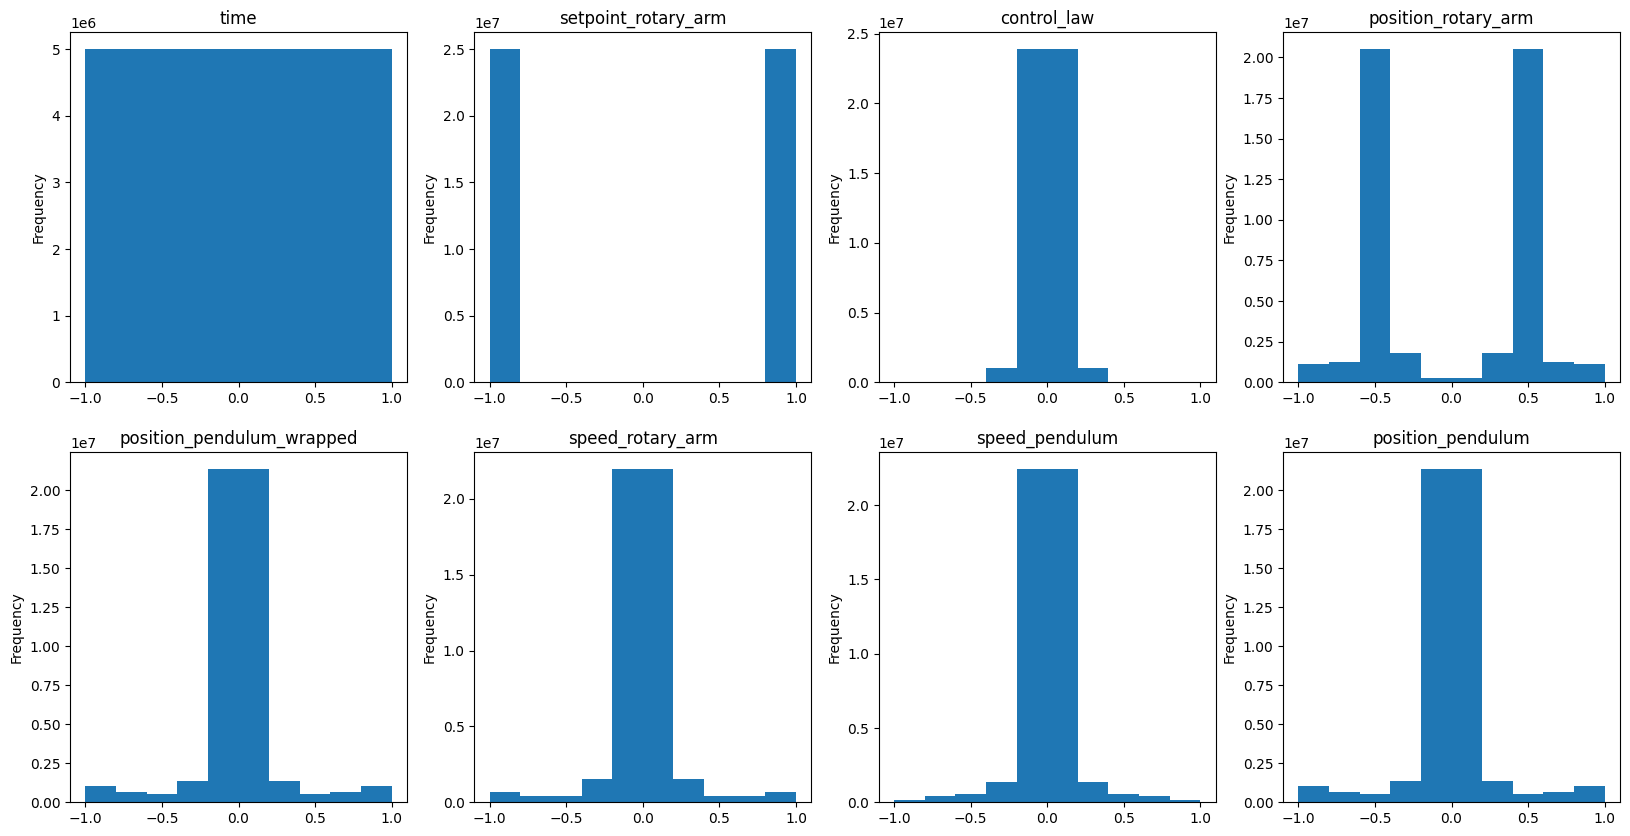

In [45]:
plot_histogram(scaled_minus1_to_1_df_data)

In [46]:
scaled_minus1_to_1_df_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,50000001.0,1.722037e-16,0.577350,-1.0,-0.500000,0.000000e+00,0.500000,1.0
setpoint_rotary_arm,50000001.0,-2.000000e-08,1.000000,-1.0,-1.000000,-1.000000e+00,1.000000,1.0
control_law,50000001.0,1.648820e-07,0.093058,-1.0,-0.000359,5.612542e-08,0.000359,1.0
position_rotary_arm,50000001.0,-6.314961e-07,0.509486,-1.0,-0.472947,-2.474545e-03,0.472947,1.0
position_pendulum_wrapped,50000001.0,3.859589e-08,0.243115,-1.0,-0.001909,5.347074e-08,0.001909,1.0
speed_rotary_arm,50000001.0,4.682470e-07,0.201608,-1.0,-0.001473,2.794866e-09,0.001473,1.0
speed_pendulum,50000001.0,2.474767e-13,0.153751,-1.0,-0.000907,2.281796e-08,0.000907,1.0
position_pendulum,50000001.0,3.859589e-08,0.243115,-1.0,-0.001909,5.347074e-08,0.001909,1.0


In [47]:
data.describe().transpose()['std']

time                         28867.514326
setpoint_rotary_arm              0.349066
control_law                      0.779599
position_rotary_arm              0.376040
position_pendulum_wrapped        0.058473
speed_rotary_arm                 1.502962
speed_pendulum                   0.748453
position_pendulum                0.058473
Name: std, dtype: float64

In [48]:
scaled_minus1_to_1_df_data.describe().transpose()['std']

time                         0.577350
setpoint_rotary_arm          1.000000
control_law                  0.093058
position_rotary_arm          0.509486
position_pendulum_wrapped    0.243115
speed_rotary_arm             0.201608
speed_pendulum               0.153751
position_pendulum            0.243115
Name: std, dtype: float64

# Scale Data with StandardScaler

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
standard_scaler = StandardScaler()
standard_scaler.fit(data)
standard_scale_data = standard_scaler.transform(data)

In [53]:
standard_scale_df = pd.DataFrame(standard_scale_data, columns=columns)

standard_scale_df.head()

,time,setpoint_rotary_arm,control_law,position_rotary_arm,position_pendulum_wrapped,speed_rotary_arm,speed_pendulum,position_pendulum
0,-1.732051,-1.0,5.373002,-0.000006,-1.587558e-07,-0.000002,-7.280890e-12,-1.587555e-07
1,-1.732051,-1.0,5.373002,-0.000006,-1.587558e-07,0.282252,5.602012e-01,-1.587555e-07
2,-1.732051,-1.0,5.129174,0.002250,1.434090e-02,0.557309,1.105698e+00,1.434090e-02
3,-1.732051,-1.0,4.699512,0.006705,4.264659e-02,0.812711,1.612032e+00,4.264659e-02
4,-1.732050,-1.0,4.139851,0.013201,8.391435e-02,1.039351,2.061412e+00,8.391435e-02


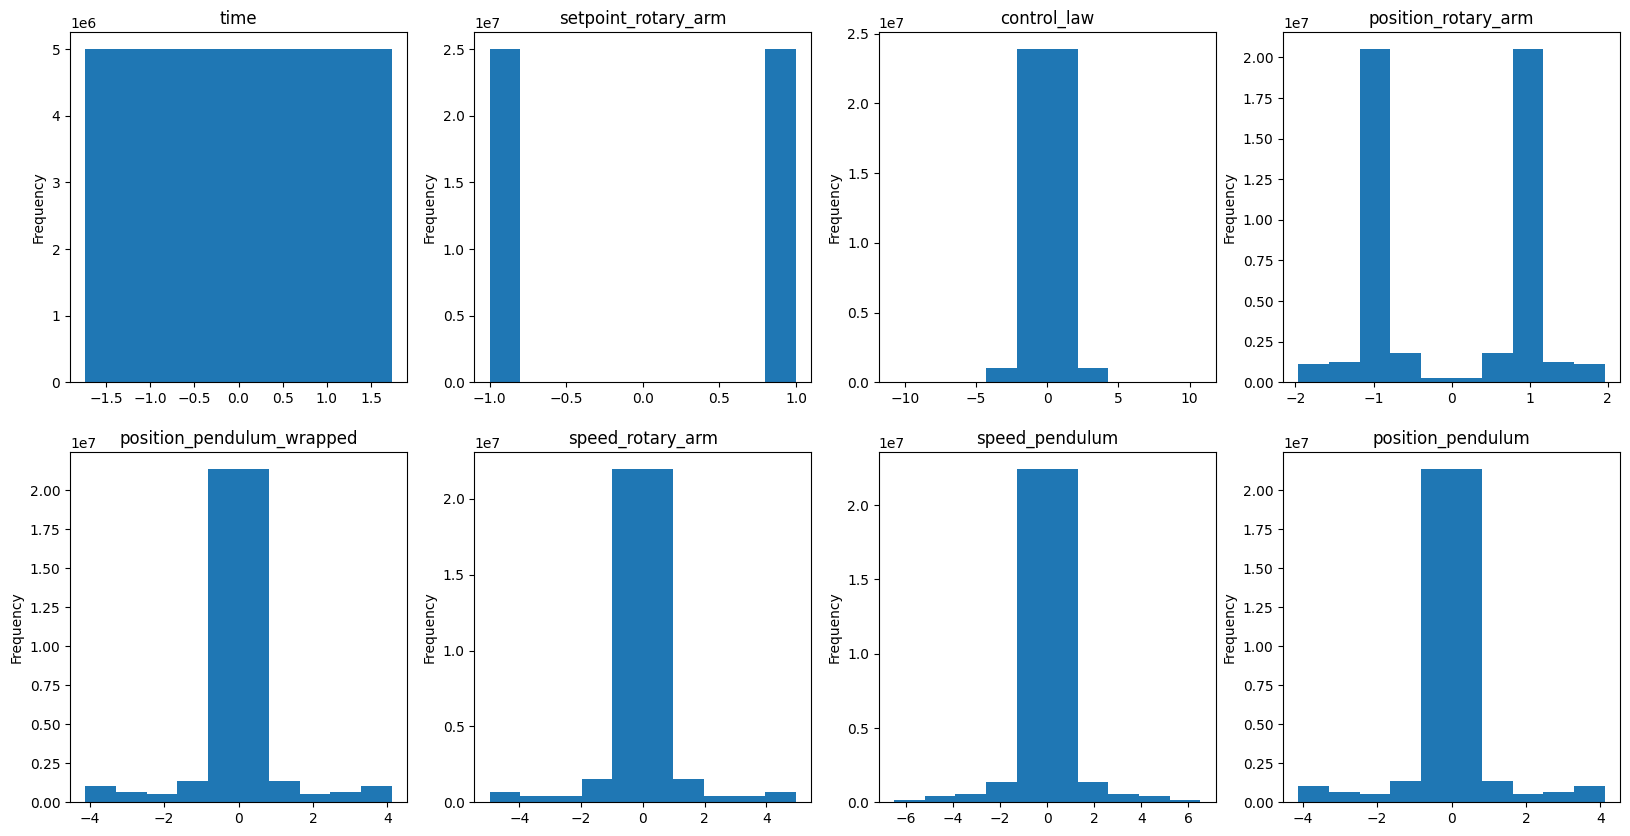

In [55]:
plot_histogram(standard_scale_df)

In [56]:
standard_scale_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,50000001.0,-6.268601e-16,1.0,-1.732051,-0.866025,-7.561397e-16,0.866025,1.732051
setpoint_rotary_arm,50000001.0,-3.223931e-16,1.0,-1.000000,-1.000000,-1.000000e+00,1.000000,1.000000
control_law,50000001.0,-2.554970e-18,1.0,-10.746015,-0.003854,-1.168700e-06,0.003852,10.746011
position_rotary_arm,50000001.0,2.492243e-17,1.0,-1.962763,-0.928282,-4.855708e-03,0.928284,1.962765
position_pendulum_wrapped,50000001.0,5.440022e-18,1.0,-4.113282,-0.007854,6.118445e-08,0.007854,4.113282
speed_rotary_arm,50000001.0,8.189431e-18,1.0,-4.960134,-0.007309,-2.308704e-06,0.007304,4.960129
speed_pendulum,50000001.0,3.816269e-19,1.0,-6.504013,-0.005897,1.484067e-07,0.005897,6.504013
position_pendulum,50000001.0,3.271123e-13,1.0,-4.113282,-0.007854,6.118477e-08,0.007854,4.113282


In [57]:
data.describe().transpose()['std']

time                         28867.514326
setpoint_rotary_arm              0.349066
control_law                      0.779599
position_rotary_arm              0.376040
position_pendulum_wrapped        0.058473
speed_rotary_arm                 1.502962
speed_pendulum                   0.748453
position_pendulum                0.058473
Name: std, dtype: float64

In [59]:
standard_scale_df.describe().transpose()['mean']

time                        -6.268601e-16
setpoint_rotary_arm         -3.223931e-16
control_law                 -2.554970e-18
position_rotary_arm          2.492243e-17
position_pendulum_wrapped    5.440022e-18
speed_rotary_arm             8.189431e-18
speed_pendulum               3.816269e-19
position_pendulum            3.271123e-13
Name: mean, dtype: float64